In [1]:
from utils.hparams import hparams,set_hparams
from preprocessing.data_gen_utils import get_pitch_parselmouth,get_pitch_crepe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import utils
import librosa
import torchcrepe
import soundfile as sf

import logging

import soundfile

from infer import infer_tool
from infer import merge
from infer.infer_tool import Svc

logging.getLogger('numba').setLevel(logging.WARNING)

# 工程文件夹名，训练时用的那个
project_name = "nyaru"
model_path = f'./checkpoints/{project_name}/model_ckpt_steps_112000.ckpt'
config_path=f'./checkpoints/{project_name}/config.yaml'
key = 0  # 音高调整，支持正负（半音）
# 加速倍数
accelerate = 50
hubert_gpu=True
svc_model = Svc(project_name,config_path,hubert_gpu, model_path)
print('model loaded')

e:\Codedata\anaconda\envs\diffsvc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


| load 'model' from '../DiffSingerRM/checkpoints/nyaru/model_ckpt_steps_112000.ckpt'.
| load 'model' from 'checkpoints/0102_xiaoma_pe/model_ckpt_steps_60000.ckpt'.
| load HifiGAN:  checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth
| Loaded model parameters from checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.pth.
| HifiGAN device: cuda.
model loaded


In [6]:
wav_fn='./raw/test_input.wav'
demoaudio, sr = librosa.load(wav_fn)
f0_tst, f0_pred, audio = svc_model.infer(wav_fn, key=key, acc=accelerate, use_pe=True, use_crepe=False, thre=0.05,
                                        use_gt_mel=False, add_noise_step=500)
ipd.display(ipd.Audio(demoaudio, rate=sr))
ipd.display(ipd.Audio(audio, rate=24000, normalize=False))
import soundfile as sf
wav_gen='test_output.wav'
sf.write(wav_gen, audio, 24000, 'PCM_16')

hubert (on cuda) time used 1.3284432888031006
===> gaussion start.


sample time step: 100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


executing 'after_infer' costed 5.379s
executing 'infer' costed 12.916s


| load HifiGAN:  checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.ckpt
Removing weight norm...
| Loaded model parameters from checkpoints/0109_hifigan_bigpopcs_hop128\model_ckpt_steps_1512000.ckpt.
| HifiGAN device: cuda.


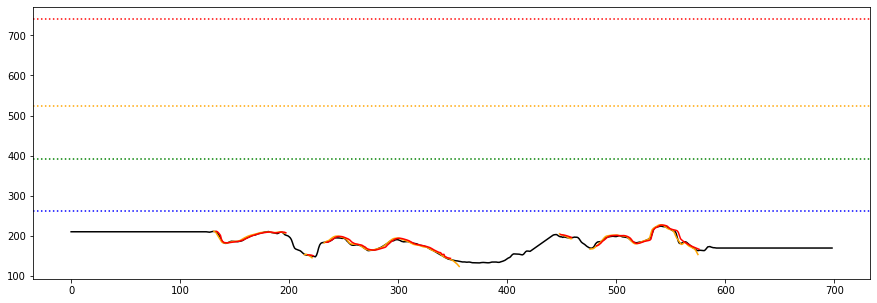

In [5]:
#f0_gen,_=get_pitch_crepe(*vocoder.wav2spec(wav_gen),hparams,threshold=0.05)
from network.vocoders.base_vocoder import VOCODERS
from network.vocoders.base_vocoder import get_vocoder_cls, BaseVocoder
  
vocoder: BaseVocoder = get_vocoder_cls(hparams)()
    
f0_gen,_=get_pitch_parselmouth(*vocoder.wav2spec(wav_gen),hparams)
f0_tst[f0_tst==0]=np.nan#ground truth f0
f0_pred[f0_pred==0]=np.nan#f0 pe predicted
f0_gen[f0_gen==0]=np.nan#f0 generated
fig=plt.figure(figsize=[15,5])
plt.plot(np.arange(0,len(f0_tst)),f0_tst,color='black')
plt.plot(np.arange(0,len(f0_pred)),f0_pred,color='orange')
plt.plot(np.arange(0,len(f0_gen)),f0_gen,color='red')
plt.axhline(librosa.note_to_hz('C4'),ls=":",c="blue")
plt.axhline(librosa.note_to_hz('G4'),ls=":",c="green")
plt.axhline(librosa.note_to_hz('C5'),ls=":",c="orange")
plt.axhline(librosa.note_to_hz('F#5'),ls=":",c="red")
#plt.axhline(librosa.note_to_hz('A#5'),ls=":",c="black")
plt.show()
